# UNIVERSIDAD ORT URUGUAY
**SANTIAGO BELZA - 286184**  
**VANESA ALLAN - 247079**

## Exploración de Métodos para Predicción de Tráfico Vehicular: Autorregresivos, Redes Recurrentes, Autoencoders y Modelos Basados en Grafos

### Contexto del Script de Análisis

El siguiente script en Python forma parte del proceso de análisis para la exploración de modelos de predicción de tráfico vehicular en el marco de la investigación realizada. Este script contiene la implementación de un modelo basado en grafos convolucionales temporales.

### Importación de librerías y carga de datos

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime, os
import typing
from geopy.distance import geodesic
from itertools import product
from sklearn.preprocessing import LabelEncoder


In [ ]:
label_encoder = LabelEncoder()
# Calcula todas las combinaciones únicas de índices de filas

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/My Drive/01_ORT_Master_en_Big_Data/09_Tesis/El_principio_del_fin/07_Datos/Dataset/Datos_transito.csv" "/content/"
#! cp "/content/drive/MyDrive/MasterBigData/Datos_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/My Drive/01_ORT_Master_en_Big_Data/09_Tesis/El_principio_del_fin/07_Datos/Dataset/data_val_transito.csv" "/content/"
#! cp "/content/drive/MyDrive/MasterBigData/data_val_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("Datos_transito.csv")
df_val = pd.read_csv('data_val_transito.csv')

### Preprocesamiento de datos

Se filtran los datos para aquellas latitudes y longitudes asociadas a la zona 5

In [ ]:
df = df.loc[df['zona'] == 5]
df_val = df_val.loc[df_val['zona'] == 5]


Para poder crear el grafo en necesario calcular las distancias entre nodos. Este actuará como valor vinculante entre vertices

In [ ]:
# Inicializa un DataFrame vacío para almacenar las distancias
df_distancia = pd.DataFrame(columns=['Id_1', 'Id_2', 'Distancia'])

In [ ]:
# Seleccionar solo las columnas de latitud y longitud y eliminar filas duplicadas
df_unique_coords = df[['latitud', 'longitud']].drop_duplicates()
df_unique_coords

,latitud,longitud
17571,-34.905258,-56.134153
23428,-34.905612,-56.135593
35142,-34.905325,-56.134761
122997,-34.886948,-56.118688
187424,-34.887157,-56.118535
204995,-34.886696,-56.109244
222566,-34.886792,-56.129075
240137,-34.887117,-56.122775
269422,-34.906759,-56.140034
480274,-34.898010,-56.124030


In [ ]:
# Codifica las latitudes y longitudes
df_unique_coords['punto_encoded'] = label_encoder.fit_transform(df_unique_coords['latitud'].astype(str) + '_' + df_unique_coords['longitud'].astype(str))
df_unique_coords

,latitud,longitud,punto_encoded
17571,-34.905258,-56.134153,18
23428,-34.905612,-56.135593,21
35142,-34.905325,-56.134761,19
122997,-34.886948,-56.118688,3
187424,-34.887157,-56.118535,5
204995,-34.886696,-56.109244,1
222566,-34.886792,-56.129075,2
240137,-34.887117,-56.122775,4
269422,-34.906759,-56.140034,25
480274,-34.898010,-56.124030,13


In [ ]:
# Codifica las latitudes y longitudes
df = pd.merge(df, df_unique_coords[['latitud', 'longitud', 'punto_encoded']], on=['latitud', 'longitud'], how='left')


In [ ]:
# Realiza un merge utilizando las columnas latitud y longitud como claves
df_val = pd.merge(df_val, df_unique_coords[['latitud', 'longitud', 'punto_encoded']], on=['latitud', 'longitud'], how='left')

In [ ]:
combinaciones_indices = product(df_unique_coords.index, repeat=2)

# Inicializa una lista para almacenar los datos de distancia
datos_distancia = []

# Itera sobre las combinaciones de índices
for idx1, idx2 in combinaciones_indices:
    # Obtén las coordenadas de los puntos
    coord_1 = (df_unique_coords.loc[idx1, 'latitud'], df_unique_coords.loc[idx1, 'longitud'])
    coord_2 = (df_unique_coords.loc[idx2, 'latitud'], df_unique_coords.loc[idx2, 'longitud'])

    coord_1_Enc = (df_unique_coords.loc[idx1, 'punto_encoded'])
    coord_2_Enc = (df_unique_coords.loc[idx2, 'punto_encoded'])

    # Calcula la distancia entre los puntos
    distancia = geodesic(coord_1, coord_2).kilometers

    # Agrega los datos de distancia a la lista
    datos_distancia.append({'Id_1': f"{coord_1[0]},{coord_1[1]}",'encoded_1': f"{coord_1_Enc}",'encoded_2': f"{coord_2_Enc}",'Id_2': f"{coord_2[0]},{coord_2[1]}", 'Distancia': distancia})


# Crea un DataFrame a partir de la lista de datos de distancia
df_distancia = pd.DataFrame(datos_distancia)

#label_encoder.fit_transform()

In [ ]:
# Dropea la columna 'Id_1' del DataFrame df_distancia
df_distancia = df_distancia.drop(columns=['Id_1','Id_2'])

# Muestra el DataFrame df_distancia
df_distancia

,encoded_1,encoded_2,Distancia
0,18,18,0.000000
1,18,21,0.137341
2,18,19,0.056062
3,18,3,2.474724
4,18,5,2.463804
...,...,...,...
724,11,15,0.568847
725,11,12,0.467713
726,11,8,0.380993
727,11,6,1.361253


In [ ]:
distancias = df_distancia.pivot(index='encoded_1', columns='encoded_2', values='Distancia')
distancias = distancias.to_numpy()
distancias = distancias.astype(str)
distancias = np.char.replace(distancias, ',', '.')
distancias = distancias.astype(float)
distancias

array([[0.        , 1.9865547 , 1.36583765, 1.58260118, 1.39823405,
        1.45851933, 1.67701502, 1.82374572, 1.86937577, 2.09682426,
        2.13753975, 2.15315516, 0.18612759, 2.20680891, 2.19794262,
        2.25312351, 2.27867093, 2.24517103, 2.42984936, 2.75464681,
        1.12569452, 0.75610551, 1.14162888, 0.22592924, 1.92391398,
        1.45610259, 1.30479036],
       [1.9865547 , 0.        , 1.83496424, 1.55865887, 1.92814206,
        1.84448323, 1.72716271, 2.12621941, 3.13983785, 2.68156588,
        3.06988112, 3.11624409, 1.81285782, 3.28172503, 3.19438516,
        3.30064377, 3.30696709, 3.08086481, 3.58806995, 3.85375111,
        0.8637634 , 1.23779879, 0.85086189, 1.81799909, 0.15422831,
        1.19361879, 1.85115737],
       [1.36583765, 1.83496424, 0.        , 0.39687539, 0.09335422,
        0.09416521, 0.37226026, 0.47408816, 1.34100516, 0.91694939,
        1.2381736 , 1.28298143, 1.23661655, 1.44705724, 1.36022377,
        1.46571362, 1.47244031, 1.26331131, 1.7546

Se castean las variables temporales al formato adecuado

In [ ]:
df['FechaHora'] = pd.to_datetime(df['FechaHora'])
df_val['FechaHora'] = pd.to_datetime(df_val['FechaHora'])

In [ ]:
df.sort_values(by='FechaHora', inplace=True)
df_val.sort_values(by='FechaHora', inplace=True)
#df = df_flow.drop(['Fecha', 'velocidad'], axis=1)

In [ ]:
df_val

,latitud,longitud,FechaHora,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona,punto_encoded
0,-34.905258,-56.134153,2023-11-01,32.333333,28.0,26 de Marzo,-34.905258-56.134153,5,18
74906,-34.897400,-56.120289,2023-11-01,20.166667,7.0,Solano Lopez,-34.8974-56.120289,5,11
72025,-34.887512,-56.129107,2023-11-01,47.666667,16.0,Solano Lopez,-34.887512-56.129107,5,6
17286,-34.886792,-56.129075,2023-11-01,30.666667,119.0,Av Italia,-34.886792-56.129075,5,2
60501,-34.904958,-56.128464,2023-11-01,29.555556,89.0,Rambla,-34.904958-56.128464,5,17
...,...,...,...,...,...,...,...,...,...
17285,-34.886696,-56.109244,2023-12-01,0.000000,0.0,Av Italia,-34.886696-56.109244,5,1
20166,-34.886792,-56.129075,2023-12-01,0.000000,0.0,Av Italia,-34.886792-56.129075,5,2
57619,-34.906333,-56.133078,2023-12-01,0.000000,0.0,Rambla,-34.906333-56.133078,5,24
66262,-34.901555,-56.123936,2023-12-01,0.000000,0.0,Rambla,-34.901555-56.123936,5,15


In [ ]:
df.set_index('FechaHora')
df_val.set_index('FechaHora')

,latitud,longitud,velocidad_agrupada,volumen_agrupada,dsc_avenida,key,zona,punto_encoded
FechaHora,,,,,,,,
2023-11-01,-34.905258,-56.134153,32.333333,28.0,26 de Marzo,-34.905258-56.134153,5,18
2023-11-01,-34.897400,-56.120289,20.166667,7.0,Solano Lopez,-34.8974-56.120289,5,11
2023-11-01,-34.887512,-56.129107,47.666667,16.0,Solano Lopez,-34.887512-56.129107,5,6
2023-11-01,-34.886792,-56.129075,30.666667,119.0,Av Italia,-34.886792-56.129075,5,2
2023-11-01,-34.904958,-56.128464,29.555556,89.0,Rambla,-34.904958-56.128464,5,17
...,...,...,...,...,...,...,...,...
2023-12-01,-34.886696,-56.109244,0.000000,0.0,Av Italia,-34.886696-56.109244,5,1
2023-12-01,-34.886792,-56.129075,0.000000,0.0,Av Italia,-34.886792-56.129075,5,2
2023-12-01,-34.906333,-56.133078,0.000000,0.0,Rambla,-34.906333-56.133078,5,24


### Ajustes de dimensionalidad de input shape

In [ ]:
flowVelocidad = pd.pivot_table(df,values='velocidad_agrupada',index='FechaHora',columns='punto_encoded', fill_value = 0, aggfunc= sum)
flowVelocidad = flowVelocidad.to_numpy()
flowVelocidad.shape

(5857, 27)

In [ ]:
flowVolumen = pd.pivot_table(df,values='volumen_agrupada',index='FechaHora',columns='punto_encoded', fill_value = 0, aggfunc= sum)
flowVolumen = flowVolumen.to_numpy()
flowVolumen.shape


(5857, 27)

In [ ]:
flowVelocidad_val = pd.pivot_table(df_val,values='velocidad_agrupada',index='FechaHora',columns='punto_encoded', fill_value = 0, aggfunc= sum)
flowVelocidad_val = flowVelocidad_val.to_numpy()
flowVelocidad_val.shape

(2881, 27)

In [ ]:
flowVolumen_val = pd.pivot_table(df_val,values='volumen_agrupada',index='FechaHora',columns='punto_encoded', fill_value = 0, aggfunc= sum)
flowVolumen_val = flowVolumen_val.to_numpy()
flowVolumen_val.shape

(2881, 27)

In [ ]:
flowVolumen_val

array([[ 15,  70, 119, ...,  67,  22,  80],
       [ 18,  54,  95, ...,  71,  26,  60],
       [ 13,  45,  78, ...,  48,  18,  65],
       ...,
       [ 46, 199, 194, ...,   0,  35, 120],
       [ 35, 168, 200, ...,   0,  38, 101],
       [  0,   0,   0, ...,   0,   0,   0]])

In [ ]:
flow = np.dstack((flowVelocidad,flowVolumen))
flow_val = np.dstack((flowVelocidad_val,flowVolumen_val))

In [ ]:
flow_val.shape

(2881, 27, 2)

In [ ]:
print(f"route_distances shape={distancias.shape}")
print(f"speeds_array shape={flow.shape}")

route_distances shape=(27, 27)
speeds_array shape=(5857, 27, 2)


### Particiones en train validation y test

En esta instancia tambien se normalizan los valores de la serie

In [ ]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(flow, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (2928, 27, 2)
validation set size: (1171, 27, 2)
test set size: (1758, 27, 2)


### Ventana de tiempo (lagging)

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):

    inputs = timeseries_dataset_from_array(
        data_array[:-forecast_horizon],
        #np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:][:, -1, -1:],# Seleccionar solo el último valor de la dimensión
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)



In [ ]:
mean, std = flow_val.mean(axis=0), flow_val.std(axis=0)

flow_val_norm = (flow_val - mean) / std

postVal_dataset = create_tf_dataset(
    flow_val_norm,
    input_sequence_length,
    forecast_horizon,
    batch_size = flow_val_norm.shape[0],
    shuffle = False,
    multi_horizon = multi_horizon,
)

### Cálculo de la matriz de adyacencia

Se trabaja con la formula sugerida en el paper de referencia

In [ ]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    num_routes = distancias.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

### Representación del nodo

In [ ]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(distancias, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 27, number of edges: 702


### Bloque de convolución

Se computan los mensajes agregados y se realizan las nuevas representaciones de los nodos en un número seleccionado de features

In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):

        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):

        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

### Bloque temporal

In [ ]:
class LSTMGC(layers.Layer):

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes

### Entrenamiento

In [ ]:
in_feat = 2
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = True
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20
46/46 [==============================] - 19s 207ms/step - loss: 0.9525 - val_loss: 1.1689
Epoch 2/20
46/46 [==============================] - 7s 151ms/step - loss: 0.5731 - val_loss: 0.8916
Epoch 3/20
46/46 [==============================] - 6s 130ms/step - loss: 0.4057 - val_loss: 0.6045
Epoch 4/20
46/46 [==============================] - 5s 112ms/step - loss: 0.3153 - val_loss: 0.4948
Epoch 5/20
46/46 [==============================] - 7s 151ms/step - loss: 0.2337 - val_loss: 0.4500
Epoch 6/20
46/46 [==============================] - 5s 116ms/step - loss: 0.1780 - val_loss: 0.3908
Epoch 7/20
46/46 [==============================] - 7s 159ms/step - loss: 0.1537 - val_loss: 0.3547
Epoch 8/20
46/46 [==============================] - 5s 112ms/step - loss: 0.1396 - val_loss: 0.3313
Epoch 9/20
46/46 [==============================] - 7s 152ms/step - loss: 0.1294 - val_loss: 0.3200
Epoch 10/20
46/46 [==============================] - 6s 128ms/step - loss: 0.1213 - val_loss: 0.322

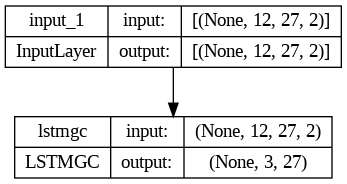

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

55/55 [==============================] - 2s 23ms/step


### Predicciones

naive MAE: 2.329093989925484, model MAE: 0.1534821457421763


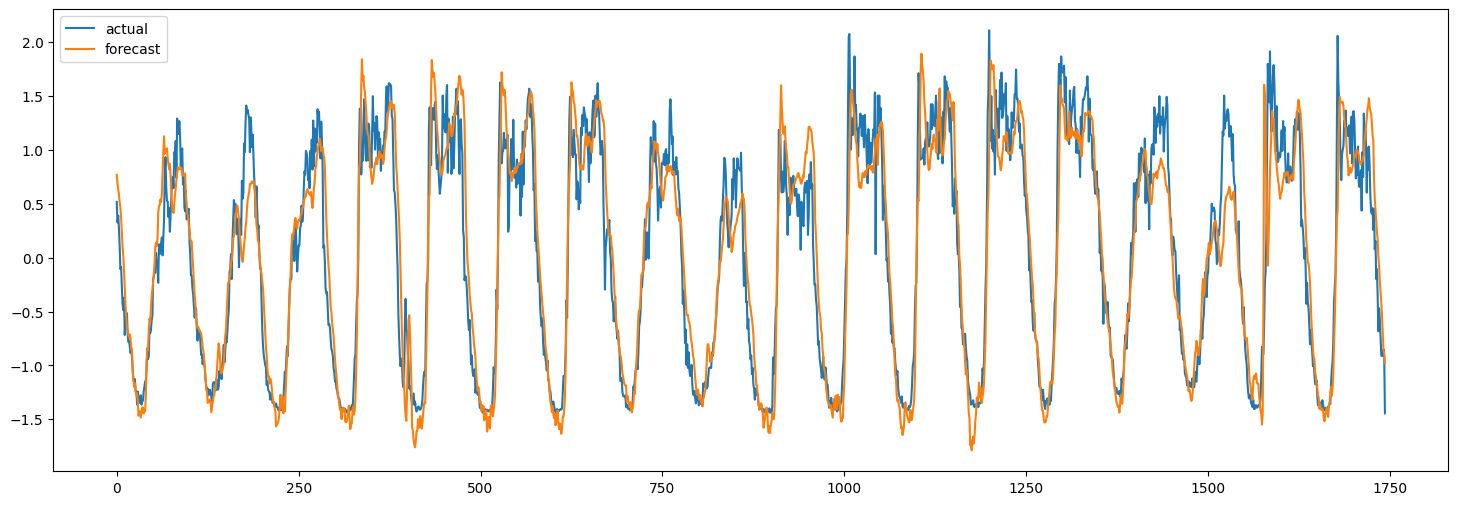

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

90/90 [==============================] - 4s 47ms/step
naive MSE: 2.096447380427303, model MSE: 0.15716617655325985


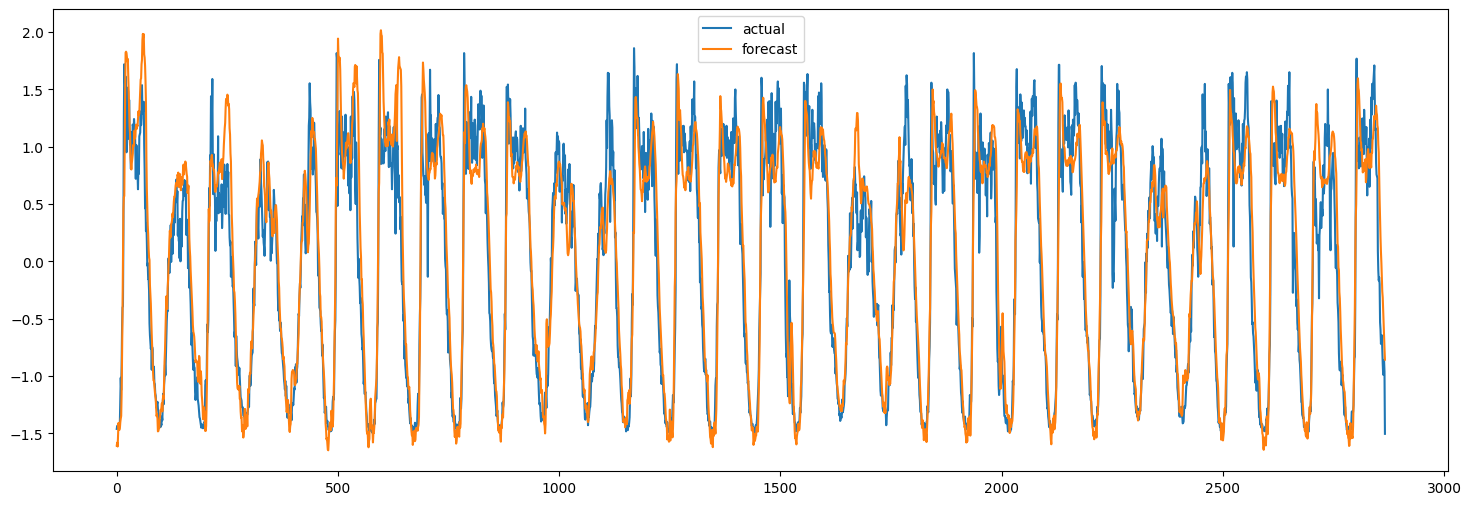

In [ ]:
x_val, y_val = next(postVal_dataset.as_numpy_iterator())
y_pred_val = model.predict(x_val)
plt.figure(figsize=(18, 6))
plt.plot(y_val[:, 0, 0])
plt.plot(y_pred_val[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_val[:, -1, :, 0] - y_val[:, 0, :]).mean(),
    np.square(y_pred_val[:, 0, :] - y_val[:, 0, :]).mean(),
)
print(f"naive MSE: {naive_mse}, model MSE: {model_mse}")